In [1]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14

C:\Users\sgkan\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


>> Use cython version


In [2]:
frequencies = np.logspace(-3, 2, 31)

### Note
- Ordering is z-up

In [3]:
layer_thicknesses = np.array([1000, 1000])
rho = np.array([1000., 10, 1000.])

mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


model_mapping = maps.IdentityMap(nP=len(rho))

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)

true_model = np.r_[np.log(1./rho), np.log(layer_thicknesses)]

dpred = simulation.dpred(true_model)

In [4]:
import matplotlib.gridspec as gridspec
def calculate_response(rho1, rho2, rho3, z, t):
    model = np.log(np.r_[1./rho3, 1./rho2, 1./rho1, t, z])
    pred = simulation.dpred(model)
#     print (simulation.rho, simulation.thicknesses)
    return pred

def plot_results(rho1, rho2, rho3, z, t, add_noise, rerr_amp, floor_phase):        
    pred = calculate_response(rho1, rho2, rho3, z, t)
    amp = pred.reshape((len(frequencies), 2))[:,0]
    phase = pred.reshape((len(frequencies), 2))[:,1]    
    if add_noise:
        noise = np.c_[np.random.randn(amp.size)*rerr_amp*abs(amp), np.random.randn(amp.size)*floor_phase].flatten()
        pred += noise
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    layer_thicknesses = np.array([z, t])
    rho = np.r_[rho1, rho2, rho3]
    plot_1d_layer_model(layer_thicknesses, rho, ax=ax0, color="k", **{'label':'True'})
    ax0.set_xlabel("Resistivity ($\Omega$m)")
    ax0.set_xlim(1, 10000)
    
    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(frequencies, pred.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
    ax.loglog(frequencies[0], pred.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
    ax_1 = ax.twinx()
    ax_1.plot(frequencies, pred.reshape((len(frequencies), 2))[:,1], color='C1')
    ax.set_xlabel("Frequency (Hz)")    
    ax.set_ylim(1, 10000)
    ax_1.set_ylim(0, 90)    
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Apparent resistivity ($\Omega$m)")
    ax_1.set_ylabel("Phase ($\degree$)")
    ax.legend(bbox_to_anchor=(-0.1, 1))
    ax.set_xlim(100, 0.001)
    plt.show()
#     plt.tight_layout()

In [5]:
from ipywidgets import widgets, interact

In [6]:
interact(
    plot_results, 
    rho1=widgets.FloatLogSlider(base=10, value=1000, min=0, max=4, continuous_update=False, description="$\\rho_1$"),
    rho2=widgets.FloatLogSlider(base=10, value=1000, min=0, max=4, continuous_update=False, description="$\\rho_2$"),
    rho3=widgets.FloatLogSlider(base=10, value=1000, min=0, max=4, continuous_update=False, description="$\\rho_3$"),
    z=widgets.FloatLogSlider(base=10, value=1000, min=0, max=5, continuous_update=False, description="$z$"),
    t=widgets.FloatLogSlider(base=10, value=1000, min=0, max=5, continuous_update=False, description="$thk$"),
    add_noise=widgets.Checkbox(),
    rerr_amp=widgets.FloatText(value=0.03),
    floor_phase=widgets.FloatText(value=5)
    
)

interactive(children=(FloatLogSlider(value=1000.0, continuous_update=False, description='$\\rho_1$'), FloatLog…

<function __main__.plot_results(rho1, rho2, rho3, z, t, add_noise, rerr_amp, floor_phase)>

In [7]:
amp = dpred.reshape((len(frequencies), 2))[:,0]
phase = dpred.reshape((len(frequencies), 2))[:,1]
std = np.c_[abs(amp)*0.03, np.ones(len(phase))*5].flatten()
noise = np.c_[np.random.randn(amp.size)*0.03*abs(amp), np.random.randn(amp.size)*5].flatten()
dobs = dpred + noise
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [8]:
starting_model = np.log(np.r_[np.ones(3)*1./2000, np.ones(2)*3000])

In [9]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization on the parameters related to resistivity
mesh_sigma = TensorMesh([mesh.hx.size])
reg_sigma = regularization.Simple(mesh_sigma, alpha_s=0.01, alpha_x=0, mapping=wire_map.sigma)

# Define the regularization on the parameters related to layer thickness
mesh_t = TensorMesh([mesh.hx.size - 1])
reg_t = regularization.Simple(mesh_t, alpha_s=0.01, alpha_x=0, mapping=wire_map.t)

# Combine to make regularization for the inversion problem
reg = reg_sigma + reg_t

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined in a list
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.34e+09  1.71e+07  0.00e+00  1.71e+07    2.18e+07      0              
   1  4.34e+09  5.53e+06  1.18e-03  1.06e+07    4.39e+06      0              
   2  4.34e+09  7.61e+06  5.72e-04  1.01e+07    1.88e+06      0              
   3  8.68e+08  6.61e+06  9.19e-04  7.41e+06    6.12e+06      0              
   4  8.68e+08  2.34e+06  2.64e-03  4.63e+06    5.59e+05      0              
   5  8.68e+08  2.09e+06  3.01e-03  4.70e+06    1.28e+05      0              
   6

<ipython-input-10-a0d7cf9176cd>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax_1.set_ylim(0, 90)


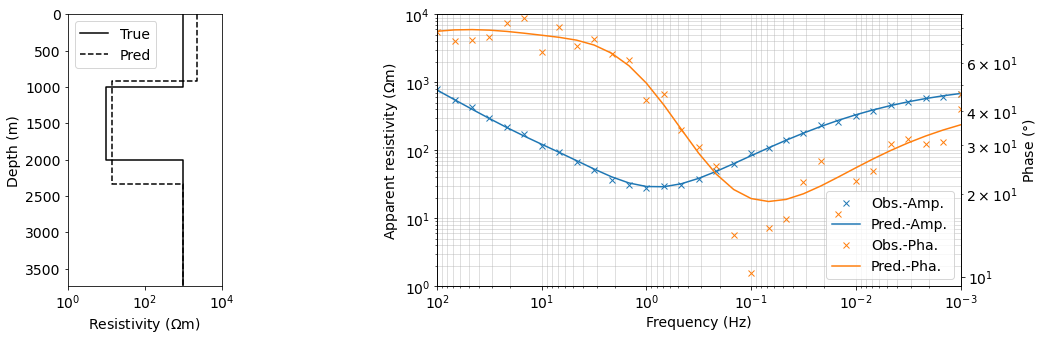

In [10]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
x_min = np.min([np.min(sigma_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(sigma_map * recovered_model), np.max(true_model)])

plot_1d_layer_model(layer_thicknesses[::-1], rho[::-1], ax=ax0, color="k", **{'label':'True'})
plot_1d_layer_model(
    (layer_map * recovered_model)[::-1],
    (1./(sigma_map * recovered_model))[::-1],
    ax=ax0,
    color="k",**{'label':'Pred', 'linestyle':'--'}
)
ax0.legend()
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-Amp.')
ax.loglog(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-Amp.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], 'x', color='C1', label='Obs.-Pha.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Pred.-Pha.')

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.loglog(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Frequency (Hz)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=4)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
ax.set_xlim(100, 0.001)

plt.show()